# Homework for statistics module

Rules for code style:
* All the code in this notebook
* Imports are provided in the head of the notebook
* All the cells could be ran in the right order from the top to the bottom
* Commentaries are required
* All the plots should have: title, axis labels and summaries (if necessary)
* Main summaries are provided in cells using markdown **(your analysis of the results and data is very important!!!)**
* Try to use functions and classes to reduce duplicated code blocks to minimum

Also you can use $\LaTeX$ to write formulas. F.e. $\bar{y} = \frac{1}{n}\sum_{i=1}^n \hat{x}_i$ or on a new line:
$$
    \bar{y} = \frac{1}{n}\sum_{i=1}^n \hat{x}_i
$$
To do so, you can write anything between $\$ \quad \$$ (or  $ \$\$ \quad\$\$ $).

### Criteria (50 points total):
* Task 1 (17 points)

    * Requested formulas are provided - 4 points
    * All necessary experiments are done - 6 points
    * Results are analysed with commentaries - 7 points
* Tasks 2.1 и 2.2 (16 points)

    * Visualization and/or simple exploratory data analysis are implemented - 2 points
    * Hypotheses are tested - 2 points
    * Results are analysed with commentaries - 4 points
* Task 3 (13 points)

    * Visualization and/or simple exploratory data analysis are implemented - 2 points
    * Hypotheses are tested - 4 points
    * Data was aggregated properly - 2 points
    * Results are analysed with commentaries - 5 points
* Extra points:

    * 4 points in case clear, "pythonic" and understandable code style.

Good work: 40+ points.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import math

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('bmh')

from pylab import rcParams

import warnings
warnings.filterwarnings('ignore')

# plots in svg look more precise
%config InlineBackend.figure_format = 'svg'

# Task 1

## Stratification

The example:

Let's assume, we need to estimate a mean votes count for every election candidate. Suppose there are 3 cities in a country: 1 million factory workers live in city A, 2 million office workers live in city B, and 3 million senior citizens live in city B. We can choose a random sample of 60 votes from the entire population, but there is some chance that the random sample will be poorly balanced between these cities and, therefore, will be biased and of little use ("average temperature in the hospital"), causing a significant error in the estimation. Instead, if we choose to use a simple random sample of 10, 20 and 30 votes from cities A, B and C, respectively, we can get a smaller error in the estimate with the same total sample size. This technique is called stratification.


### The task

Suppose the population is a mixture of 3 normally distributed CBs. In other words, the population can be divided into 3 strata.
$$
    F(X) = a_1 F(X_1) + a_2 F(X_2) + a_3 F(X_3)
$$

**Goals:**  

1. Derive (for example, in the block below, using Markdown) the formulas for point estimates of the mathematical expectation and variance for the average value of subsamples formed in different ways:
- random selection from the entire population;
- random selection of strata in proportion to strata volumes;
- random selection according to the optimal sub-sampling.

2. Calculate point estimates of the mathematical expectation and variance of the mean value for each data sampling method from p.1, provided:
* Experiments should be conducted for 3 cases (for every method from p.1 each):
     * all strata have the same mat. expectations and variance;
     * strata have different mat. expectations, but the same variance;
     * strata have different mat. expectations and variance.
* For each sampling method plot histogram of General Population data (using matplotlib or seaborn packages);
* Plot boxplots for sample mean estimated using each sampling method on a single figure to compare the results. Repeat for each experiment.
* You are provided with `GeneralPopulation` class. It already has all necessary methods for sampling and creating general population as a mixture of strata.
* Your goal is to write functions to conduct experiments and visualize the results.   
* Also provide commentaries as summaries and analysis of results after each visualization.


## Solution for Task 1

### Formulas:

#### Stratified sample point estimations:


Within the $k_th$ strata let’s take a sample of volume $n_k$:
<br>
$$
(X_{1k}, ..., X_{n_{k}k}) \quad \quad  k = \overline{1, L}
$$


**it's sample mean:**

$$\overline{X}_k = \frac{1}{n_k} \sum_{i=1}^{n_k} X_{ik}$$ 

**It's sample variance:**

$$D_k^* = \frac{1}{n_k} \sum_{i=1}^{n_k} (X_{ik} - \overline{X}_k)^2$$

#### Sample volumes if they are sampled proportionally:


Sample volumes $n_1,…,n_L$

$$
n_k = nW_k \quad \quad k = \overline{1, L} \quad \quad  n = n_1 + ... + n_L
$$


where $W_k$ - strata’s ratio

#### Sample volumes if they are optimal sampled (Neyman's method):


*Theorem for **Neyman allocation** (so-called <b>Optimal sampling</b>):*

Sample volumes $n_1,…,n_L$ those

$$
\tilde{n}_k = n\frac{W_{k}\sigma_k}{\sum_{k=1}^{L} W_{k}\sigma_k}  \quad \quad  k = \overline{1, L} \quad \quad  n = n_1 + ... + n_L
$$

minimize variance $D(\overline{X}_S)$

So, for strata *k* with volume $n_k$ the resulted sample volume will be $\tilde{𝑛}_k$.

**GeneralPopulation class**  
Already has methods for creating general population as a mixture of strata, for generating subsample with random, optimal and stratified techniques:

In [2]:
class GeneralPopulation:

  def __init__(self, 
               means: [float], 
               stds: [float], 
               sizes: [int], 
               random_state: int = 15
               ):
    """
    Initializes our General Population and saves the given distributions
    
    :param means: List of expectations for normal distributions
    :param stds: List of standard deviations for normal distributions
    :param sizes: How many objects will be in each strata
    :param random_state: Parameter fixing randomness. Needed so that when conducting
    experiment repeatedly with the same input parameters, the results remained the same
    """
    self.strats = [st.norm(mean, std) for mean, std in zip(means, stds)]
    self._sample(sizes)
    self.random_state = random_state

  def _sample(self, sizes):
        """Creates a general population sample as a mixture of strata
        
        :param sizes: List with sample sizes of the corresponding normal distributions
        """
        self.strats_samples = [rv.rvs(size) for rv, size in zip(self.strats, sizes)]
        self.general_samples = np.hstack(self.strats_samples)
        self.N = self.general_samples.shape[0]
        
        # number of strata
        self.count_strats = len(sizes)
        
        # ratios for every strata in GP
        self.ws = [size/self.N for size in sizes]
        
        # ME and Std for GP
        self.m = np.mean(self.general_samples)
        self.sigma = np.std(self.general_samples)
        
        # ME and std for all strata
        self.ms = [np.mean(strat_sample) for strat_sample in self.strats_samples]
        self.sigmas = [np.std(strat_sample) for strat_sample in self.strats_samples]

  def random_subsampling(self, size):
      """Creates a random subset of the entire population
      
      :param sizes: subsample size
      """
      rc = np.random.choice(self.general_samples, size=size) 
      return rc
      
  def proportional_subsampling(self, size):
      """Creates a subsample with the number of elements, proportional shares of strata
      
      :param sizes: subsample size
      """
      self.strats_size_proport = [int(np.floor(size*w)) for w in self.ws]
      
      rc = []
      for k in range(len(self.strats_size_proport)):
          rc.append(np.random.choice(self.strats_samples[k],
                                      size=self.strats_size_proport[k]))
      
      return rc
      
  def optimal_subsampling(self, size):
      """Creates a subsample with the optimal number of elements relative to strata
      
      :param sizes: subsample size
      """
      sum_denom = 0
      for k in range(self.count_strats):
          sum_denom += self.ws[k] * self.sigmas[k]
      
      self.strats_size_optimal = [int(np.floor((size*w*sigma)/sum_denom)) for w, sigma in zip(self.ws, self.sigmas)]
      if 0 in self.strats_size_optimal:
          raise ValueError('Strats size is 0, please change variance of smallest strat!')
      
      rc = []
      for k in range(len(self.strats_size_optimal)):
          rc.append(np.random.choice(self.strats_samples[k],
                                      size=self.strats_size_optimal[k]))
      
      return rc   

  def run_experiments(self, n_sub, subsampling_method, n_experiments=1000):
      """Conducts a series of experiments and saves the results
      
      :param subsampling_method: method for creating a subsample
      :param n_experiments: number of experiment starts
      """
      means_s = []
      
      if(len(self.general_samples)<100):
          n_sub = 20
      
      if(subsampling_method == 'random_subsampling'):
          for n in range(n_experiments):
              rc = self.random_subsampling(n_sub)
              
              mean = rc.sum()/len(rc)
              means_s.append(mean)
              
      else:
          for n in range(n_experiments):
              if(subsampling_method == 'proportional_subsampling'):
                  rc = self.proportional_subsampling(n_sub)
              elif(subsampling_method == 'optimal_subsampling'):
                  rc = self.optimal_subsampling(n_sub)
              
              strats_mean = []
      
              for k in range(len(rc)):
                  strats_mean.append(sum(rc[k])/len(rc[k]))
      
              # Mean for a mixture
              means_s.append(sum([w_k*mean_k for w_k, mean_k in zip(self.ws, strats_mean)]))
              
      return means_s

Function for histogram plot:

In [3]:
"""HERE IS YOUR CODE
It should be implemented as follows:
* Takes a GeneralPopulation class instance;
* Uses matplotlib or seaborn packages to plot distribution for general population;
* Don't forget a title, grid etc. 
"""

lst = ["random_subsampling", "proportional_subsampling", "optimal_subsampling"]


def plot_hist(dist, title="title name", hist=True, bins=75):
    sns.set(style="darkgrid")
    f, ax = plt.subplots(3, 1, figsize=(10, 15))
    f.suptitle(title)
    for i, key in enumerate(lst):
        ax[i].set_title(key)
        temp = dist.run_experiments(n_sub=20, subsampling_method=key)
        sns.distplot(temp, hist=hist, bins=bins, ax=ax[i])
    plt.show()

Function for plotting Boxplots for sample mean:

In [4]:
"""HERE IS YOUR CODE
It should be implemented as follows:
* Takes a GeneralPopulation class instance;
* Runs method `run_experiments` for each sampling method and gets vector of mean values;
* Uses matplotlib or seaborn packages to plot boxplots of mean values for each subsampling techniques;
* Axis Y == Mean values; Axis X == subsampling methods;
* Don't forget a title, grid etc. 
"""


def plot_boxplot(dist, title="title name", orient='v'):
    sns.set(style="darkgrid")
    f, ax = plt.subplots(figsize=(10, 7))
    f.suptitle(title)
    lst_of_val = []
    for i, key in enumerate(lst):
        temp = dist.run_experiments(n_sub=20, subsampling_method=key)
        lst_of_val.append(temp)
    df = pd.DataFrame(data=np.array(lst_of_val).transpose(), columns=lst)

    sns.boxplot(data=df, orient=orient)
    plt.show()

**Parameters for each General Population**  
You can use these or specify your own parameters for strata:

In [5]:
SIZES = (150, 150, 150)
N_SUBSAMPLE = 150
EQUAL_MEAN_EQUAL_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 3, 3], 'sizes': SIZES}
DIFFERENT_MEAN_EQUAL_STDS_ARGS = {'means': [15, -1, -17], 'stds': [3, 3, 3], 'sizes':SIZES}
EQUAL_MEAN_DIFFERENT_STDS_ARGS = {'means': [0, 0, 0], 'stds': [3, 7, 11], 'sizes':SIZES}

**Initialization**

In [6]:
# Create GeneralPopulation class instances here
a = GeneralPopulation(**EQUAL_MEAN_EQUAL_STDS_ARGS)
b = GeneralPopulation(**DIFFERENT_MEAN_EQUAL_STDS_ARGS)
c = GeneralPopulation(**EQUAL_MEAN_DIFFERENT_STDS_ARGS)

**General population with EQUAL means and EQUAL STDs of strata**  
Distribution histogram:

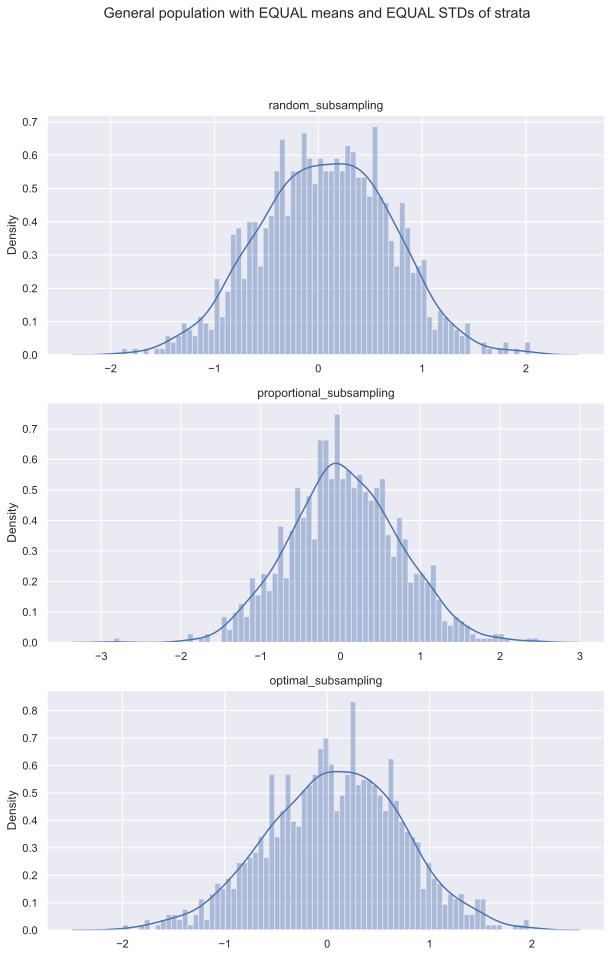

In [7]:
plot_hist(a, "General population with EQUAL means and EQUAL STDs of strata")

Boxplots for sample mean:

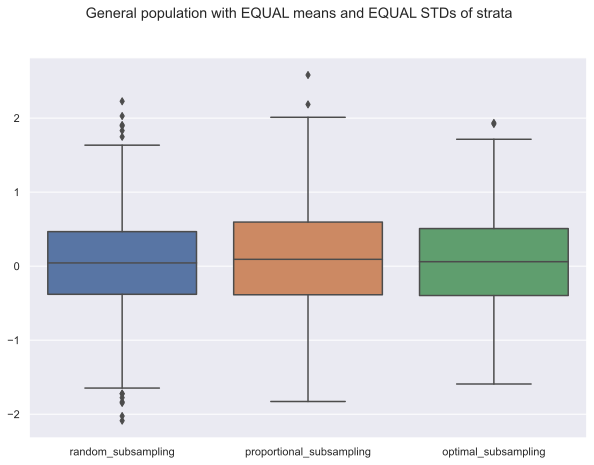

In [8]:
plot_boxplot(a, "General population with EQUAL means and EQUAL STDs of strata")

**General population with DIFFERENT means and EQUAL STDs of strata**  
Distribution histogram:

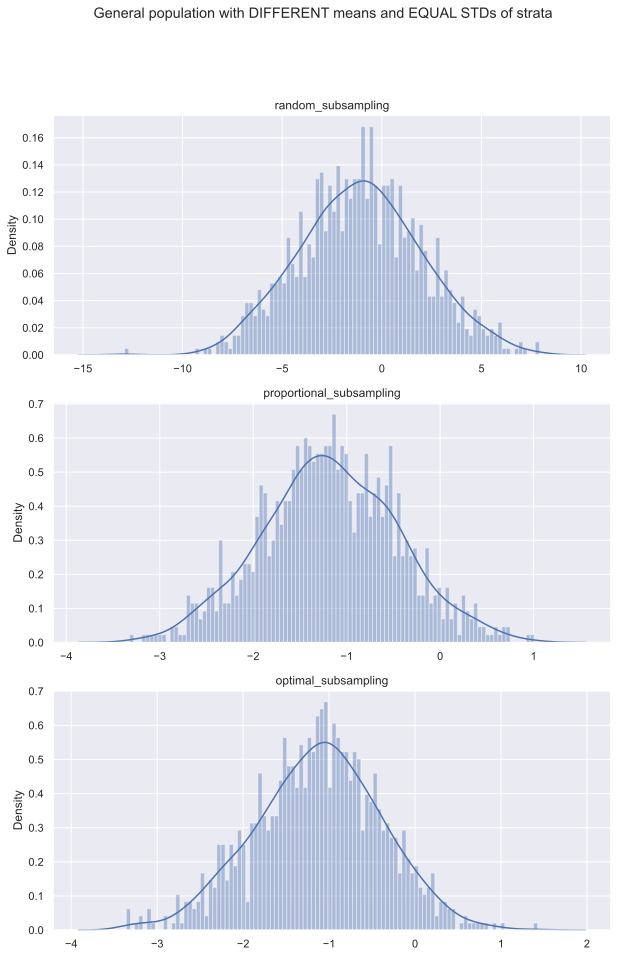

In [9]:
plot_hist(b, "General population with DIFFERENT means and EQUAL STDs of strata", bins=100)

Boxplots for sample mean:

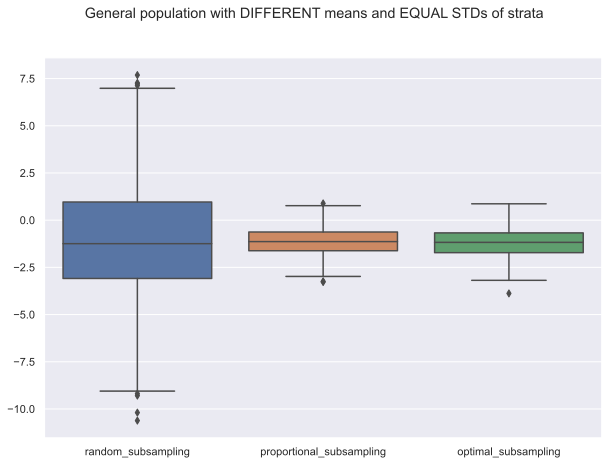

In [10]:
plot_boxplot(b, title="General population with DIFFERENT means and EQUAL STDs of strata")

**General population with DIFFERENT means and DIFFERENT STDs of strata**  
Distribution histogram:

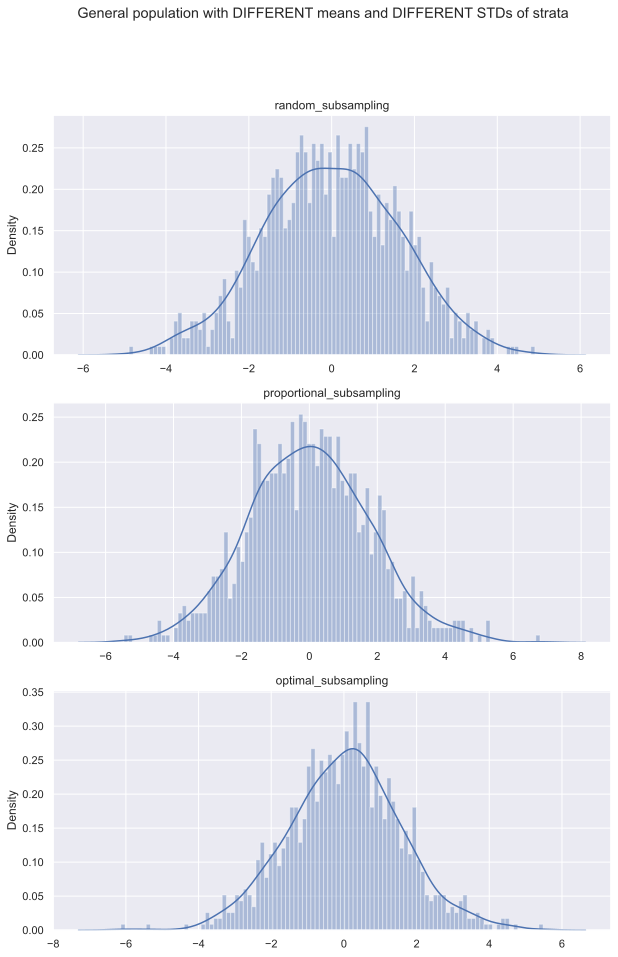

In [11]:
plot_hist(c, "General population with DIFFERENT means and DIFFERENT STDs of strata", bins=100)

Boxplots for sample mean:

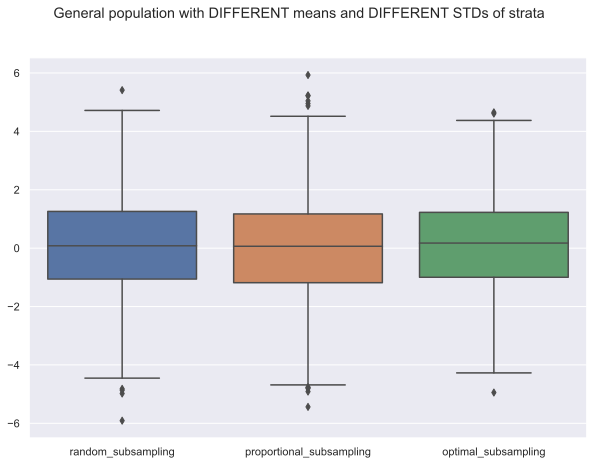

In [12]:
plot_boxplot(c,title="General population with DIFFERENT means and DIFFERENT STDs of strata")

With the experiments conducted and statistics estimated we can generate these <b>conclusions</b>: 


Sampling helps a lot in research. It is one of the most important factors which determines the accuracy of your research/survey result. If anything goes wrong with your sample then it will be directly reflected in the final result. 

**Population** is the collection of the elements which has some or the other characteristic in common. Number of elements in the population is the size of the population.

**Sample** is the subset of the population. The process of selecting a sample is known as sampling. Number of elements in the sample is the sample size.



- Random sampling technique uses randomization to make sure that every element of the population gets an equal chance to be part of the selected sample. Every element has an equal chance of getting selected to be the part sample. It is used when we don’t have any kind of prior information about the target population.

- Proportionate sampling is a sampling strategy (a method for gathering participants for a study) used when the population is composed of several subgroups that are vastly different in number. The number of participants from each subgroup is determined by their number relative to the entire population. We can find out the disctribution of the sample proportion if the sample size is less than 5% pf the total population size. If np(1-p) >= 10, the distribution of the sample proportion is approximately normal. Standard Deviation of the sampling dist is:

$$\sigma_p = \sqrt{\frac{p(1-p)}{n}}$$ 
 
- Optimal sampling determines the most information-rich times to sample the system, allowing robust parameter estimates to be determined from the minimal number of samples. 


Basing on boxplots we can conclude that:

    Optimal sampling helped to generate samples with lower sample mean variance. Thus the interquartile range is lower both for sample variance and sample mean. But if the stratas’ EV and Variances are equal, there is no such an advantage.
    
    

# Task 2



### Part 1
Using [this criteria](https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/how-to/correlation/interpret-the-results/#:~:text=For%20the%20Pearson%20correlation%2C%20an,linear%20relationship%20between%20the%20variables.&text=If%20both%20variables%20tend%20to,represents%20the%20correlation%20slopes%20upward.), check whether there is a correlation between a brain size and intelligence for a dataset consisted both of men and women objects. Also check it for men and women subsamples separately.


### Part 2
Using $Chi^2$ criteria check whether there is a statistical difference between men's and women's choice of auto.  (Features `Sex` и `PreferCar`)


You can download dataset using the following:

In [13]:
from bds_courseware import read_drive_dataset
from bds_courseware import HOMEWORK_DATASETS
brain_data = read_drive_dataset(*HOMEWORK_DATASETS['brain'])  # PART 1
cars_prefes_data = read_drive_dataset(*HOMEWORK_DATASETS['car_perfs'])  # PART 2

### Part_1 - solution


Let's make some EDA. 

In order to understand our data, we can look at each variable and try to understand their meaning and relevance to this problem.

1. `Gender`: Male or Female
2. `FSIQ`: Full Scale IQ scores based on the four Wechsler (1981) subtests
3. `VIQ`: Verbal IQ scores based on the four Wechsler (1981) subtests
4. `PIQ`: Performance IQ scores based on the four Wechsler (1981) subtests
5. `Weight`: body weight in pounds
6. `Height`: height in inches
7. `MRI_Count`: total pixel Count from the 18 MRI scans




**to do list:**
- convert Weight and Height to numerical values
- deal with NaNs in Weight and Height
- detect and deal with outliers


- concatenate `FSIQ`, `VIQ`, `PIQ` as they are strongly linearly correlated. I will sum them and devide by 3. New value we will call new_iq. <b>Please, comment this if I am wrong</b>  


- Use 


**General info**

* Before using corr, we should prepare our data (e.g. deal with outliers)
* Definitely all features are significant. But the way I see it, it is better to detect correlation between MRI_Count and new_iq params

<AxesSubplot:title={'center':'pearson correlation'}>

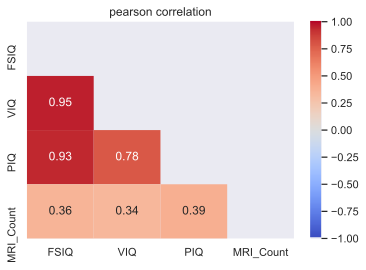

In [14]:
f, ax  = plt.subplots()
ax.set_title('pearson correlation')

matrix = np.triu(brain_data.corr())
sns.heatmap(brain_data.corr(), vmin=-1, vmax=1,
            cmap='coolwarm', annot=True, center=0, mask=matrix)

In [15]:
brain_data_test = brain_data.copy()

brain_data_test["main_iq"] = (brain_data["FSIQ"] + brain_data["VIQ"] + brain_data["PIQ"]) / 3
brain_data_test.drop(labels=["FSIQ", "VIQ", "PIQ"], axis=1, inplace=True)

# how i can transform this in more easiest way, answer please :3
brain_data_test.loc[[1,20], "Weight"] = np.nan
brain_data_test.loc[20, "Height"] = np.nan

brain_data_test[["Height", "Weight"]] = brain_data_test[["Height","Weight"]].astype(float, errors="ignore")

brain_data_test.loc[[1,20], "Weight"] = brain_data_test.median(axis=0)["Weight"]
brain_data_test.loc[20, "Height"] = brain_data_test.median(axis=0)["Weight"]

In [16]:
# I want to divide numerical and categorical features in order to make some magical visualisation
continious_features = brain_data_test.select_dtypes('number').columns
categorical_features = brain_data_test.select_dtypes(np.object).columns

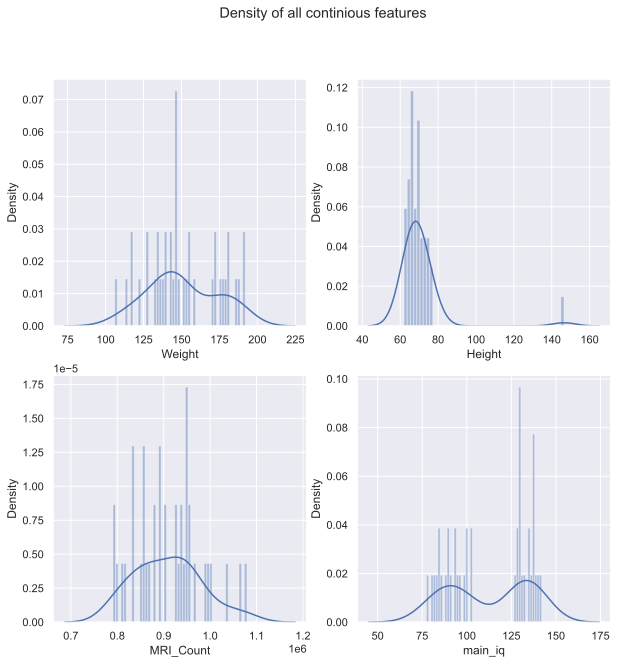

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(10,10))
fig.suptitle('Density of all continious features')

for key, val in enumerate(continious_features):
    sns.distplot(a=brain_data_test[val],bins=50, hist=True, kde=True, ax=axs[key // 2][key % 2])

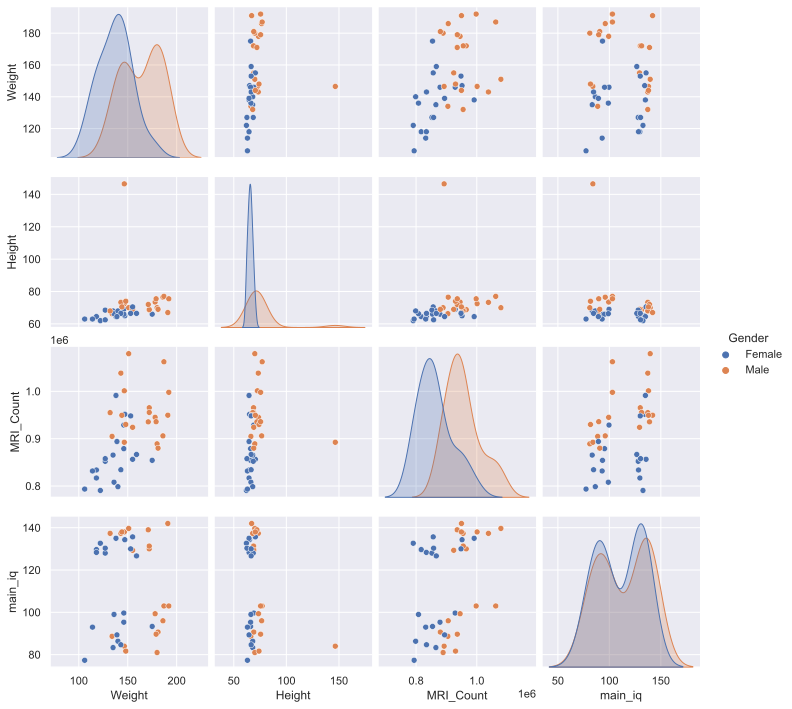

In [18]:
sns.pairplot(brain_data_test,  hue = 'Gender')
plt.show()

In [19]:
brain_data_test[brain_data_test["Height"] > 120] 
# 146 inc 365,76 cm. It is outliers!!!

,Gender,Weight,Height,MRI_Count,main_iq
20,Male,146.5,146.5,892420,84.0


So, we detect **outliers**. I think we should replace it with median value. After that we can use heatmap in order to detect correlation.

In [20]:
brain_data_test.loc[20,"Height"] = brain_data_test.median(axis=0)["Height"]

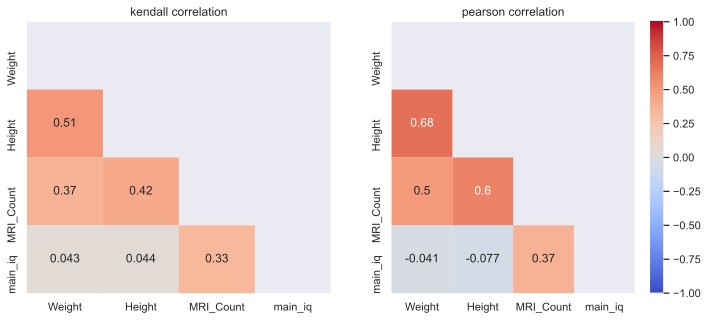

In [21]:
f, ax  = plt.subplots(1, 2, figsize=(12, 5))
matrix = np.triu(brain_data_test.corr())
ax[0].set_title('kendall correlation')
ax[1].set_title('pearson correlation')

sns.heatmap(brain_data_test.corr(method='kendall'), ax = ax[0],
            vmin=-1, vmax=1, cmap='coolwarm', annot=True, mask=matrix, cbar=False, )

sns.heatmap(brain_data_test.corr(), vmin=-1, ax=ax[1],
            vmax=1, cmap='coolwarm', annot=True, mask=matrix )
plt.show()

Yea. There is a correcalion between Height and Weight, but we will not take it into account.

There is a correlation between our main values: `MRI_Count` and `main_iq`. However, it is not so strong correlation. Lets divide our dataset into 2 groups (male and female) and check the correlation values. 

In [22]:
brain_data_male = brain_data_test[brain_data_test["Gender"] == "Male"]
brain_data_female = brain_data_test[brain_data_test["Gender"] == "Female"]


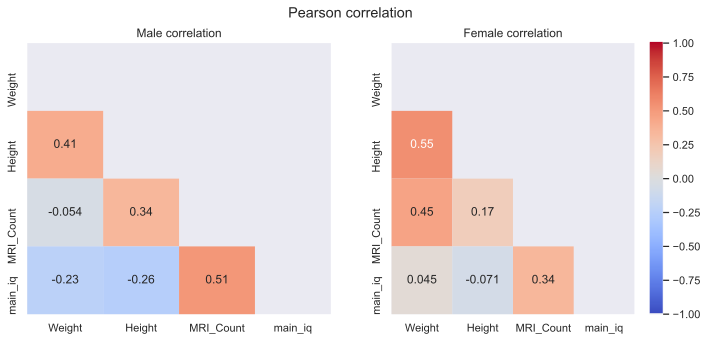

In [23]:
f, ax  = plt.subplots(1, 2, figsize=(12, 5))
matrix_0 = np.triu(brain_data_male.corr())
matrix_1 = np.triu(brain_data_female.corr())

ax[0].set_title('Male correlation')
ax[1].set_title('Female correlation')
f.suptitle('Pearson correlation')


sns.heatmap(brain_data_male.corr(), ax = ax[0],
            vmin=-1, vmax=1, cmap='coolwarm', annot=True, cbar=False, mask=matrix_1)

sns.heatmap(brain_data_female.corr(), vmin=-1, ax=ax[1],
            vmax=1, cmap='coolwarm', annot=True, mask=matrix_0)
plt.show()

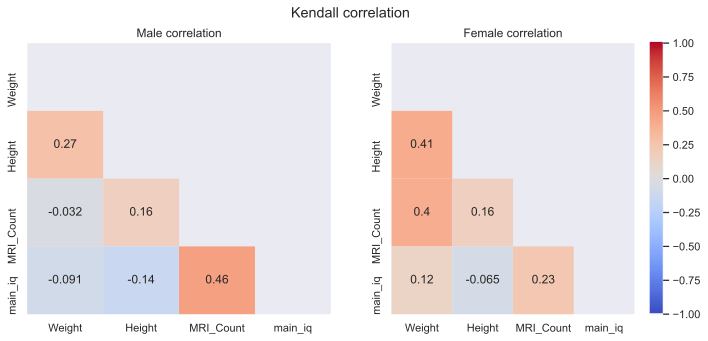

In [24]:
f, ax  = plt.subplots(1, 2, figsize=(12, 5))
matrix_0 = np.triu(brain_data_male.corr())
matrix_1 = np.triu(brain_data_female.corr())
f.suptitle('Kendall correlation')

ax[0].set_title('Male correlation')
ax[1].set_title('Female correlation')

sns.heatmap(brain_data_male.corr(method="kendall"), ax = ax[0],
            vmin=-1, vmax=1, cmap='coolwarm', annot=True, cbar=False, mask=matrix_1)

sns.heatmap(brain_data_female.corr(method="kendall"), vmin=-1, ax=ax[1],
            vmax=1, cmap='coolwarm', annot=True, mask=matrix_0)
plt.show()

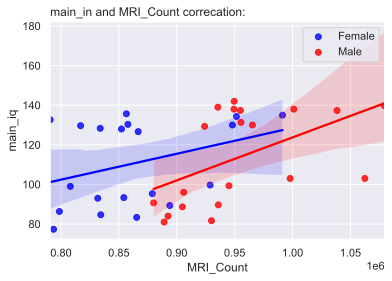

In [25]:
fig, ax = plt.subplots()
colors = ["blue", "red"]

for i, value in enumerate(brain_data_test["Gender"].unique()):
    ax = sns.regplot(x="MRI_Count", y="main_iq", ax=ax,
                     data=brain_data_test[brain_data_test["Gender"] == value],
                     label=value,
                     color=colors[i],
                     )

plt.title('main_in and MRI_Count correcation:', loc='left')

ax.legend(loc='best')
display(fig)
plt.close('all')



**Conclusion:**
Definitely we can see correlation between the size of the brain and IQ tests results. We can also contribute that the relationship is stronger for males than females.


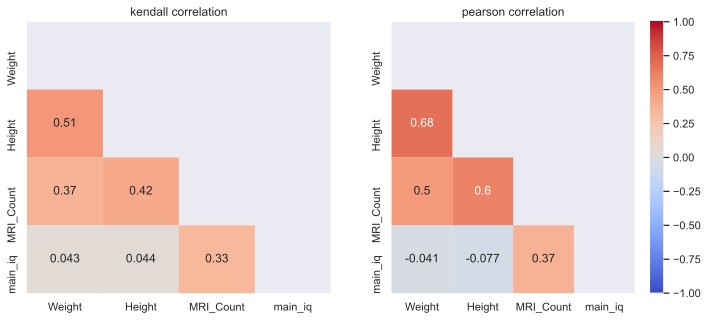

In [26]:
# I just wanted to check how normalization affect on correlation. As to be expected, it does not affect on correlation.

from sklearn.preprocessing import StandardScaler
scaled_features = StandardScaler().fit_transform(brain_data_test[continious_features])
scaled_features_df = pd.DataFrame(scaled_features, index=brain_data_test.index, columns=continious_features)


f, ax  = plt.subplots(1, 2, figsize=(12, 5))
matrix = np.triu(scaled_features_df.corr())
ax[0].set_title('kendall correlation')
ax[1].set_title('pearson correlation')

sns.heatmap(scaled_features_df.corr(method='kendall'), ax = ax[0],
            vmin=-1, vmax=1, cmap='coolwarm', annot=True, mask=matrix, cbar=False)

sns.heatmap(scaled_features_df.corr(), vmin=-1, ax=ax[1],
            vmax=1, cmap='coolwarm', annot=True, mask=matrix)
plt.show()

#### Part_2 - solution


    Using  𝐶ℎ𝑖2  criteria check whether there is a statistical difference between men's and women's choice of auto. (Features Sex и PreferCar)


In [27]:
cars_prefes_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,300.0,209.986667,108.131562,1.0,117.75,206.5,307.25,393.0
Age,300.0,34.123333,15.344695,18.0,21.00,27.0,46.00,75.0
Sex,300.0,1.500000,0.500835,1.0,1.00,1.5,2.00,2.0
LicYr,300.0,15.240000,14.424376,0.0,3.00,9.0,26.00,57.0
LicMth,300.0,0.620000,1.995547,0.0,0.00,0.0,0.00,11.0
ActCar,300.0,2.000000,0.817861,1.0,1.00,2.0,3.00,3.0
Kids5,300.0,1.903333,0.295997,1.0,2.00,2.0,2.00,2.0
Kids6,300.0,1.736667,0.441178,1.0,1.00,2.0,2.00,2.0
PreferCar,300.0,2.170000,0.866180,1.0,2.00,2.0,3.00,4.0
Car15K,300.0,1.536667,0.499487,1.0,1.00,2.0,2.00,2.0


In [28]:
cars_prefes_data.Sex.value_counts()

2    150
1    150
Name: Sex, dtype: int64

In [29]:
cars_prefes_data['PreferCar'].value_counts()

2    136
3     73
1     68
4     23
Name: PreferCar, dtype: int64

<AxesSubplot:title={'center':'marital and y'}>

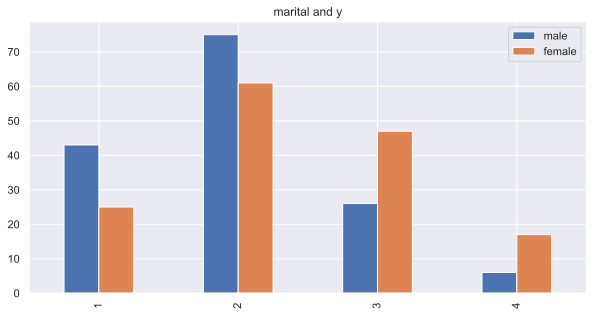

In [30]:
dfg = pd.DataFrame()

dfg['male'] = cars_prefes_data[cars_prefes_data['Sex'] == 1]['PreferCar'].value_counts().sort_index()
dfg['female'] = cars_prefes_data[cars_prefes_data['Sex'] == 2]['PreferCar'].value_counts().sort_index()

dfg.plot.bar(title = 'marital and y', figsize=(10,5))

By this plot we can conclude that the choice of car doesn't depent on "sex". But it is better to chach on this chriteria.

it is better to divide out dataset by "sex".  

In [31]:
male_car = cars_prefes_data[cars_prefes_data['Sex'] == 1][['Sex', 'PreferCar']].astype('category')
female_car = cars_prefes_data[cars_prefes_data['Sex'] == 2][['Sex', 'PreferCar']].astype('category')

In [32]:
# this func provider us with all data about chriteria. 

from scipy.stats import chi2_contingency
from scipy.stats import chi2


def Chi2_criteria(df):
    stat, p, dof, expected = chi2_contingency(df)
    print('dof=%d' % dof)
    # interpret test-statistic
    prob = 0.95
    critical = chi2.ppf(prob, dof)
    print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
    if abs(stat) >= critical:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')
    
    # interpret p-value
    alpha = 1.0 - prob
    print('significance=%.3f, p=%.3f' % (alpha, p))
    if p <= alpha:
        print('Dependent (reject H0)')
    else:
        print('Independent (fail to reject H0)')

In [33]:
Chi2_criteria(male_car)

dof=149
probability=0.950, critical=178.485, stat=16.281
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)


In [34]:
Chi2_criteria(female_car)

dof=149
probability=0.950, critical=178.485, stat=24.464
Independent (fail to reject H0)
significance=0.050, p=1.000
Independent (fail to reject H0)


As we mentioned above, it is no doubt that the choice of car doesn't depent on "sex" since our $H_0$ say that there is no statistical difference between men's and women's choice of auto.

In [35]:
stat, p, dof, expected = chi2_contingency(female_car)
print(p)

1.0


# Task 3

You can find and download a dataset there:
https://www.kaggle.com/russellyates88/suicide-rates-overview-1985-to-2016


1) For any country (you are free to choose any of the presented) 
 *  Visualize a feature **suicides_no** considering other features: **sex**, **age** (or **generation**) and year;
 *  Check whether there is statistical difference for suicide number between these groups: men / women. If it is found, can we claim that people of certain sex are more prone to suicides or do we need additional information?

2) For 2016: divide countries into 3-4 groups according to the values of the **gdp_per_capita** feature (use statistical characteristics to determine how to divide the data into groups), check if the suicides / 100k pop indicator differs in these groups. Do not forget that for each country you have several values and they need to be aggregated or checked for each group separately.

In [36]:
df = pd.read_csv('master.csv')
df.describe().T

,count,mean,std,min,25%,50%,75%,max
year,27820.0,2.001258e+03,8.469055e+00,1985.000,1995.000,2002.000,2008.000,2.016000e+03
suicides_no,27820.0,2.425744e+02,9.020479e+02,0.000,3.000,25.000,131.000,2.233800e+04
population,27820.0,1.844794e+06,3.911779e+06,278.000,97498.500,430150.000,1486143.250,4.380521e+07
suicides/100k pop,27820.0,1.281610e+01,1.896151e+01,0.000,0.920,5.990,16.620,2.249700e+02
HDI for year,8364.0,7.766011e-01,9.336671e-02,0.483,0.713,0.779,0.855,9.440000e-01
gdp_per_capita ($),27820.0,1.686646e+04,1.888758e+04,251.000,3447.000,9372.000,24874.000,1.263520e+05


In [37]:
df.country.unique()

array(['Albania', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Barbados', 'Belarus', 'Belgium', 'Belize',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cabo Verde',
       'Canada', 'Chile', 'Colombia', 'Costa Rica', 'Croatia', 'Cuba',
       'Cyprus', 'Czech Republic', 'Denmark', 'Dominica', 'Ecuador',
       'El Salvador', 'Estonia', 'Fiji', 'Finland', 'France', 'Georgia',
       'Germany', 'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hungary',
       'Iceland', 'Ireland', 'Israel', 'Italy', 'Jamaica', 'Japan',
       'Kazakhstan', 'Kiribati', 'Kuwait', 'Kyrgyzstan', 'Latvia',
       'Lithuania', 'Luxembourg', 'Macau', 'Maldives', 'Malta',
       'Mauritius', 'Mexico', 'Mongolia', 'Montenegro', 'Netherlands',
       'New Zealand', 'Nicaragua', 'Norway', 'Oman', 'Panama', 'Paraguay',
       'Philippines', 'Poland', 'Portugal', 'Puerto Rico', 'Qatar',
       'Republic of Korea', 'Romania', '

In [38]:
from sklearn import preprocessing

data = df[df["country"] == "Russian Federation"]
data = data[["sex", "age", "year", "suicides_no"]]
data["sex"].replace(('male', 'female'), (1, 0), inplace=True)
le = preprocessing.LabelEncoder()
data.age = le.fit_transform(data.age)

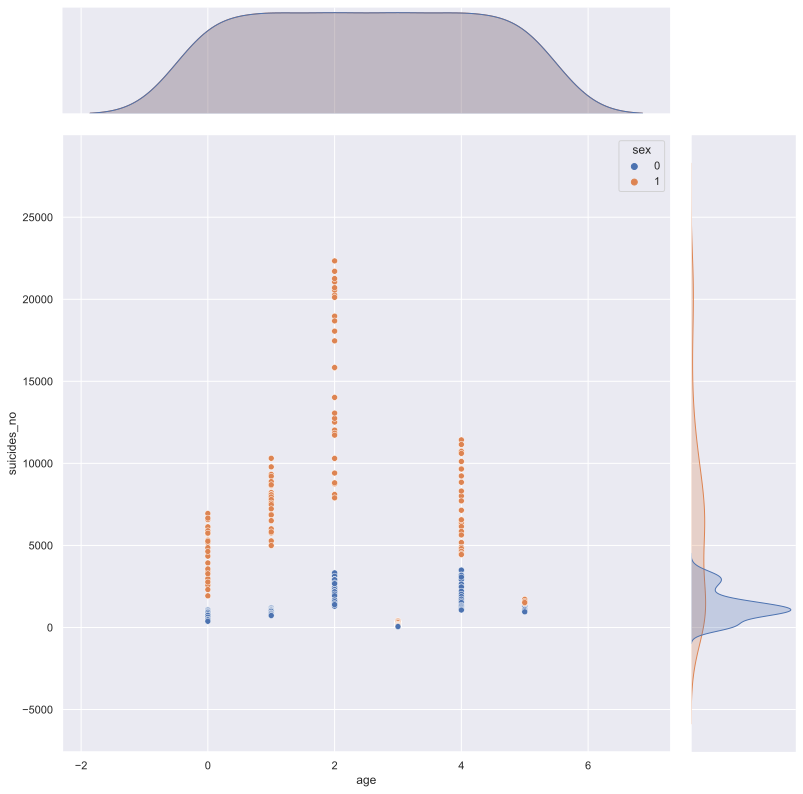

In [39]:
sns.jointplot(x=data['age'],
              y=data['suicides_no'], hue=data["sex"])
plt.gcf().set_size_inches(12, 12)

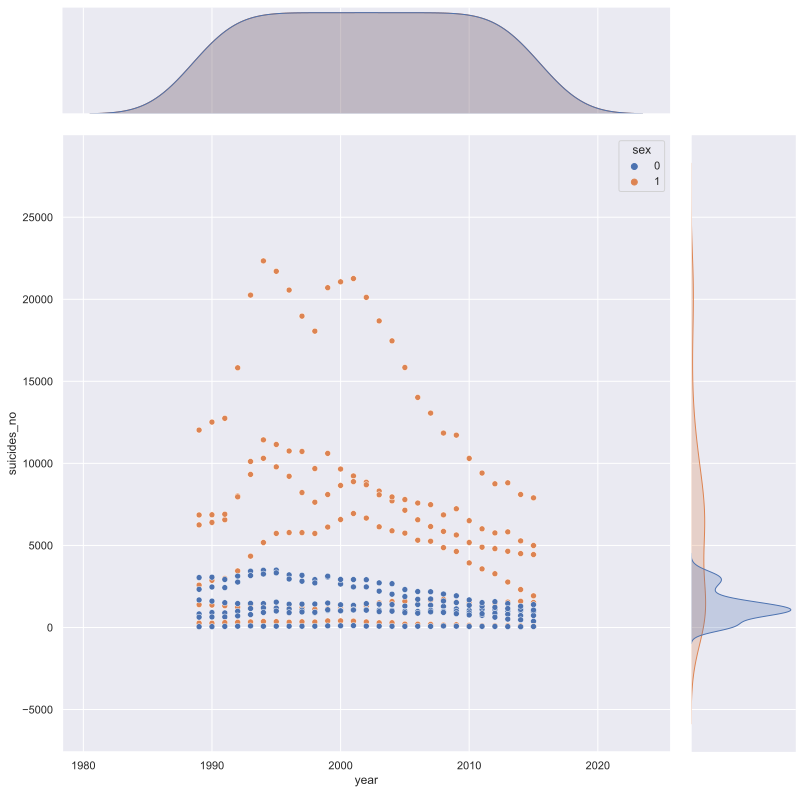

In [40]:
sns.jointplot(x=data['year'],
              y=data['suicides_no'], hue=data["sex"])
plt.gcf().set_size_inches(12, 12)

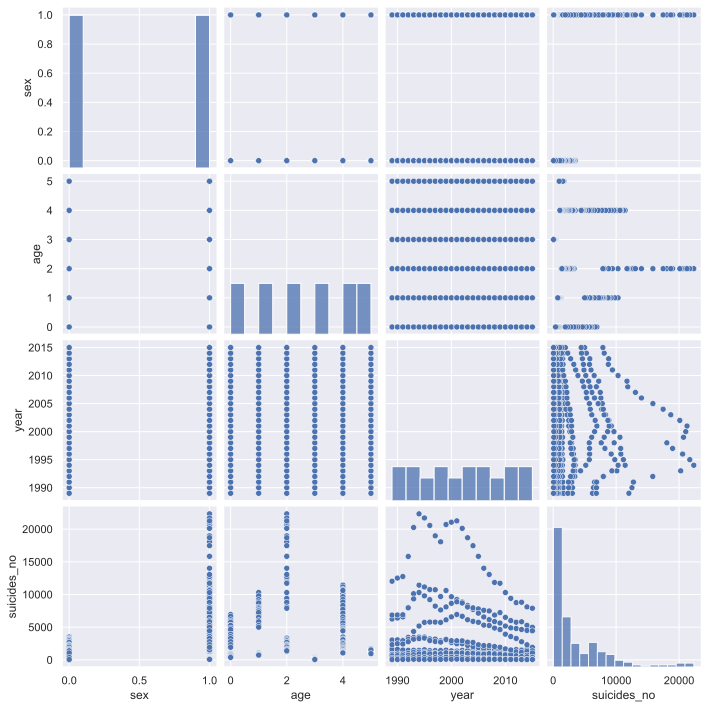

In [41]:
sns.pairplot(data)
plt.show()

<AxesSubplot:title={'center':'boxplot of suicides_no in Russia'}, ylabel='suicides_no'>

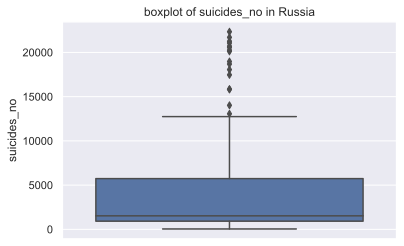

In [42]:
plt.title("boxplot of suicides_no in Russia")
sns.boxplot(y=data.suicides_no)

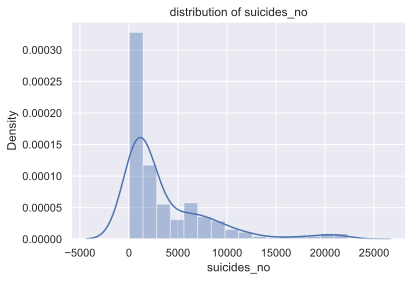

In [43]:
sns.distplot(data['suicides_no'])
plt.title("distribution of suicides_no")
plt.show()

<AxesSubplot:title={'center':'distribution of suicides_no in Russia with male and female'}, xlabel='year', ylabel='suicides_no'>

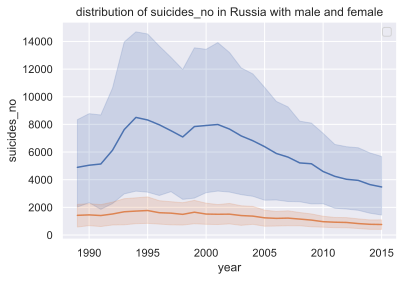

In [44]:
plt.legend(["male", 'female'])
plt.title("distribution of suicides_no in Russia with male and female")

df_men = data[data.sex == 1]
df_women = data[data.sex == 0]

sns.lineplot(x=df_men['year'], y=df_men['suicides_no'])
sns.lineplot(x=df_women['year'], y=df_women['suicides_no'])


The number of suicides with male are higher than with female. Moreover it doesnt matter which year it is,